In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from dataset_utils import read_many_hdf5

if tf.test.gpu_device_name(): 
  print(f"Default GPU Device: {tf.test.gpu_device_name()}")

Default GPU Device: /device:GPU:0


In [2]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [3]:
class SEBlock(layers.Layer):
  def __init__(self, shape, ratio=16):
    super(SEBlock, self).__init__()
    self.dense1 = layers.Dense(shape//ratio, activation="relu")
    self.dense2 = layers.Dense(shape, activation="sigmoid")
  
  def call(self, input_tensor):
    x = layers.GlobalAveragePooling2D()(input_tensor)
    x = self.dense1(x)
    x = self.dense2(x)
    return layers.Multiply()([input_tensor, x])


class SE_ResNetBlock(layers.Layer):
  def __init__(self, filters):
    super(SE_ResNetBlock, self).__init__()
    self.conv2a = layers.Conv2D(filters, (1,1))
    self.bna = layers.BatchNormalization()

    self.se = SEBlock(filters)

    self.conv2b = layers.Conv2D(filters, (1,1))
    self.bnb = layers.BatchNormalization()

  def call(self, input_tensor):
    x1 = self.conv2a(input_tensor)
    x = self.bna(x1)

    x = self.conv2b(x)
    x = self.bnb(x)

    x = self.se(x)

    x = layers.Add()([x, x1])
    return tf.nn.relu(x)

class ViCTORIA(tf.keras.Model):
  def __init__(self, filters, nb_blocks=6):
    super(ViCTORIA, self).__init__(name="ViCTORIA")

    self.conv2a = layers.Conv2D(filters, (1, 1))
    self.bna = layers.BatchNormalization()

    self.conv2b = layers.Conv2D(filters, (1, 1))
    self.bnb = layers.BatchNormalization()

    self.blocks = []
    for _ in range(nb_blocks):
      self.blocks.append(SE_ResNetBlock(filters))
    
    self.dense = layers.Dense(1, activation="linear")
  
  def call(self, input_tensor):
    x = self.conv2a(input_tensor)
    x = self.bna(x)
    x = tf.nn.relu(x)

    for block in self.blocks:
      x = block(x)

    x = self.conv2b(x)
    x = self.bnb(x)
    x = tf.nn.relu(x)

    x = layers.Flatten()(x)

    return self.dense(x)

In [4]:
directory = "E:/IA/Deep_ViCTORIA/Datasets/SE_ResNet/"
positions_train, scores_train = read_many_hdf5(49637, directory, "_train")
positions_test, scores_test = read_many_hdf5(16896, directory, "_test")
scores_train = scores_train.reshape(-1, 1)
scores_test = scores_test.reshape(-1, 1)

In [5]:
models = []
for i in range(1, 5):
  model = ViCTORIA(filters=64, nb_blocks=i)
  model.build((1, 8, 8, 15))
  model.compile(loss='mean_absolute_error', optimizer="adam", metrics=[coeff_determination])
  models.append(model)

In [6]:
nb_epochs = 20
histories = []
for i, model in enumerate(models):
  print(f"Model {i+1}/{len(models)}...", end=" ")
  history = model.fit(positions_train, scores_train, verbose=0, epochs=nb_epochs)
  histories.append(history)
  print("Done.")

Model 1/4... Epoch 1/20
1552/1552 [==============================] - 18s 9ms/step - loss: 418.7050 - coeff_determination: 0.0138
Epoch 2/20
1552/1552 [==============================] - 14s 9ms/step - loss: 292.0984 - coeff_determination: 0.4821
Epoch 3/20
1552/1552 [==============================] - 15s 10ms/step - loss: 274.5888 - coeff_determination: 0.5324
Epoch 4/20
1552/1552 [==============================] - 15s 10ms/step - loss: 268.2231 - coeff_determination: 0.5452
Epoch 5/20
1552/1552 [==============================] - 16s 10ms/step - loss: 263.2575 - coeff_determination: 0.5613
Epoch 6/20
1552/1552 [==============================] - 15s 9ms/step - loss: 259.2700 - coeff_determination: 0.5694
Epoch 7/20
1552/1552 [==============================] - 14s 9ms/step - loss: 254.7768 - coeff_determination: 0.5777
Epoch 8/20
1552/1552 [==============================] - 15s 9ms/step - loss: 251.8640 - coeff_determination: 0.5847
Epoch 9/20
1552/1552 [==============================] - 

In [7]:
def plot_results(histories, X_test, y_test, path=None):
  epochs = range(1, nb_epochs + 1)

  _, axs = plt.subplots(1, 2, figsize=(20, 5))
  _, ax_score  = plt.subplots(1, 1, figsize=(10, 5))

  for i, history in enumerate(histories):
    loss = history.history["loss"]
    score = history.history["coeff_determination"]
    axs[0].plot(epochs, loss, label=f"{i + 1} SENet blocks")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("(Mean Absolute Error)")
    axs[0].set_title('Training loss')

    axs[1].plot(epochs, score, label=f"{i + 1} SENet blocks")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("($R^2$)")
    axs[1].set_title('Training score')


    preds = models[i](X_test)
    r2_score = coeff_determination(tf.convert_to_tensor(y_test), preds).numpy()
    ax_score.scatter(y_test, preds, label = f"{i + 1} SENet blocks $R^2 = {r2_score:.2f}$")
    ax_score.set_xlabel("True values")
    ax_score.set_ylabel("Predictions")
    ax_score.set_title("Results")

  ma = np.max(y_test)
  mi = np.min(y_test)
  x = np.linspace(ma, mi, 100)
  ax_score.plot(x, x, label = "Predictions = True values")
  ax_score.legend()
  for ax in axs:
    ax.legend()

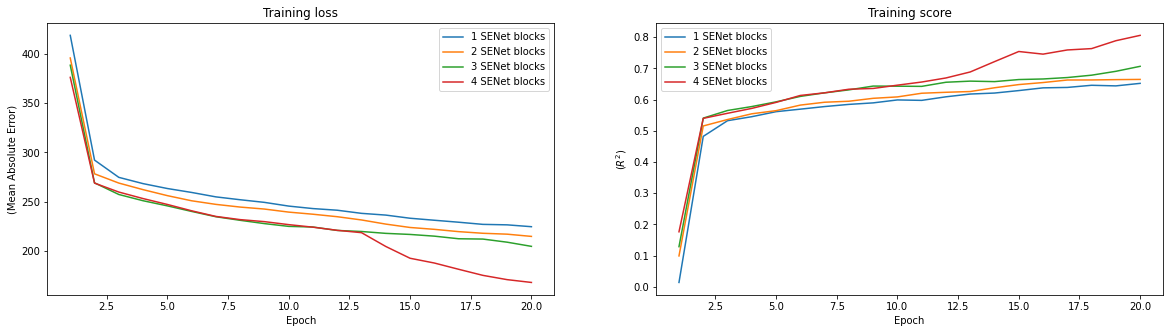

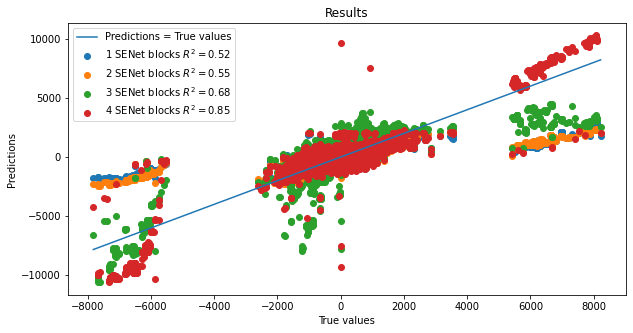

In [8]:
plot_results(histories, positions_train, scores_train)